<a href="https://colab.research.google.com/github/Joan947/mini_LLM/blob/main/ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 5: Pretraining on Unlabeled Data

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.12.0
torch version: 2.8.0+cu126
tensorflow version: 2.19.0


- In this chapter, we implement the training loop and code for basic model evaluation to pretrain an LLM
- At the end of this chapter, we also load openly available pretrained weights from OpenAI into our model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/01.webp" width=500px>

- The topics covered in this chapter are shown below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp" width=400px>

## 5.1 Evaluating generative text models

- We start this section with a brief recap of initializing a GPT model using the code from the previous chapter
- Then, we discuss basic evaluation metrics for LLMs
- Lastly, in this section, we apply these evaluation metrics to a training and validation dataset

### 5.1.1 Using GPT to generate text

- We initialize a GPT model using the code from the previous chapter

In [2]:
import torch
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens
  - This is so that more readers will be able to follow and execute the code examples on their laptop computer
  - However, please feel free to increase the `context_length` to 1024 tokens (this would not require any code changes)
  - We will also load a model with a 1024 `context_length` later from pretrained weights

- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/03.webp" width=500px>

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "To get to the"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 To get to the aliノ analogy bankElement Approach Crimes projection packages stren


- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

<br>

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

- Suppose we have an `inputs` tensor containing the token IDs for 2 training examples (rows)
- Corresponding to the `inputs`, the `targets` contain the desired token IDs that we want the model to generate
- Notice that the `targets` are the `inputs` shifted by 1 position, as explained in chapter 2 when we implemented the data loader

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- Feeding the `inputs` to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each
- Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary
- Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- The figure below, using a very small vocabulary for illustration purposes, outlines how we convert the probability scores back into text, which we discussed at the end of the previous chapter

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/04.webp" width=500px>

- As discussed in the previous chapter, we can apply the `argmax` function to convert the probability scores into predicted token IDs
- The softmax function above produced a 50,257-dimensional vector for each token; the `argmax` function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token

- Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[ 7718],
         [47747],
         [30424]],

        [[49906],
         [29471],
         [23689]]])


- If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens:

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: car onlook frontal


- That's because the model wasn't trained yet
- To train the model, we need to know how far it is away from the correct predictions (targets)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/06.webp" width=500px>

- The token probabilities corresponding to the target indices are as follows:

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([4.9342e-05, 3.6148e-05, 1.2251e-05])
Text 2: tensor([1.9275e-05, 3.6511e-05, 3.6072e-06])


- We want to maximize all these values, bringing them close to a probability of 1
- In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself; this is out of the scope of this book, but I have recorded a lecture with more details here: [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [11]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.9167, -10.2279, -11.3099, -10.8567, -10.2179, -12.5326])


- Next, we compute the average log probability:

In [12]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8436)


- The goal is to make this average log probability as large as possible by optimizing the model weights
- Due to the log, the largest possible value is 0, and we are currently far away from 0

- In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the *negative* average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
- The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning

In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8436)


- PyTorch already implements a `cross_entropy` function that carries out the previous steps

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/07.webp" width=400px>

- Before we apply the `cross_entropy` function, let's check the shape of the logits and targets

In [14]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- For the `cross_entropy` function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize
- The `cross_entropy` function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8436)


- A concept related to the cross-entropy loss is the perplexity of an LLM
- The perplexity is simply the exponential of the cross-entropy loss

In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(51205.6445)


- The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
- In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
- Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

### 5.1.3 Calculating the training and validation set losses

- We use a relatively small dataset for training the LLM (in fact, only one short story)
- The reasons are:
  - You can run the code examples in a few minutes on a laptop computer without a suitable GPU
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
  - We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size


- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
  - At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately \\$30
  - So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * \\$30 =  \\$690,000

- Below, we use the same dataset we used in chapter 2

In [18]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.


# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode('utf-8')
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 99 characters

In [19]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [20]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/09.webp" width=500px>

In [22]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [23]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- Llama 2 7B was trained with a batch size of 1024, for example

- An optional check that the data was loaded correctly:

In [24]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:

In [25]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Next, we implement a utility function to calculate the cross-entropy loss of a given batch
- In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.994720035129124
Validation loss: 10.968436241149902


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp" width=400px>

## 5.2 Training an LLM

- In this section, we finally implement the code for training the LLM
- We focus on a simple training function (if you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code))

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/11.webp" width=300px>

In [28]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- Now, let's train the LLM using the training function defined above:

In [29]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="To get to the", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.335
To get to the,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.600
To get to the, the,, and,,,,,,,,,.                                   
Ep 3 (Step 000020): Train loss 5.586, Val loss 6.477
Ep 3 (Step 000025): Train loss 5.523, Val loss 6.399
To get to the, and, and, and, and, and, and, and of the of the of the of the to the St, and, and the of the of the to the, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.128, Val loss 6.366
Ep 4 (Step 000035): Train loss 4.941, Val loss 6.366
To get to the a a, and a a of the of the a of the. Gis. I had been. I had been. Gisburn. I had a of the of the of the of the of the of the of the of the of the
Ep 5 (Step 000040): Train loss 4.340, Val loss 6.246
To get to the, I had been a--I had been--I had been his of the of the pi

- Note that you might get slightly different loss values on your computer, which is not a reason for concern if they are roughly similar (a training loss below 1 and a validation loss below 7)
- Small differences can often be due to different GPU hardware and CUDA versions or small changes in newer PyTorch versions
- Even if you are running the example on a CPU, you may observe slight differences; a possible reason for a discrepancy is the differing behavior of `nn.Dropout` across operating systems, depending on how PyTorch was compiled, as discussed [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

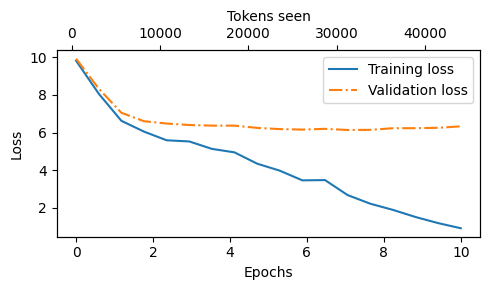

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
- Later, we will cover decoding strategies that can mitigate this memorization by a certain degree
- Note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/13.webp" width=350px>

**If you are interested in augmenting this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping, please refer to [Appendix D](../../appendix-D/01_main-chapter-code)**

**If you are interested in a larger training dataset and longer training run, see [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 Decoding strategies to control randomness

- Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above
- Using the `generate_text_simple` function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time
- As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary

In [31]:
# NEW: use CPU here as inference is cheap with
# this model and to ensure readers get same results in the
# remaining sections of this book
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("To get to the", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 To get to the sunburnt cheeks furrowed by a smile that lifted the tips of a self-confident moustache, I


- Even if we execute the `generate_text_simple` function above multiple times, the LLM will always generate the same outputs
- We now introduce two concepts, so-called decoding strategies, to modify the `generate_text_simple`: *temperature scaling* and *top-k* sampling
- These will allow the model to control the randomness and diversity of the generated text

### 5.3.1 Temperature scaling

- Previously, we always sampled the token with the highest probability as the next token using `torch.argmax`
- To add variety, we can sample the next token using The `torch.multinomial(probs, num_samples=1)`, sampling from a probability distribution
- Here, each index's chance of being picked corresponds to its probability in the input tensor

- Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:

In [36]:
vocab = {
    "closer": 0,
    "they": 1,
    "got": 2,
    "forward": 3,
    "inches": 4,
    "to": 5,
    "pizza": 6,
    "toward": 7,
    "the": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [37]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- Instead of determining the most likely token via `torch.argmax`, we use `torch.multinomial(probas, num_samples=1)` to determine the most likely token by sampling from the softmax distribution
- For illustration purposes, let's see what happens when we sample the next token 1,000 times using the original softmax probabilities:

In [38]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x they
0 x got
582 x forward
2 x inches
0 x to
0 x pizza
343 x toward
0 x the


- We can control the distribution and selection process via a concept called temperature scaling
- "Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0
- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

- Note that the resulting dropout outputs may look different depending on your operating system; you can read more about this inconsistency [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

In [39]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

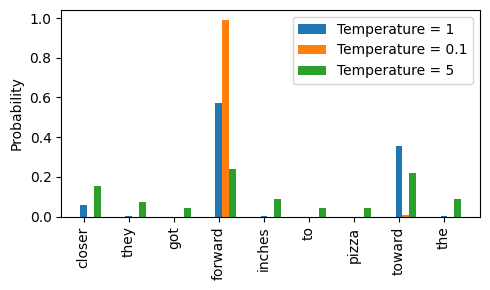

In [40]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- We can see that the rescaling via temperature 0.1 results in a sharper distribution, approaching `torch.argmax`, such that the most likely word is almost always selected:

In [41]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x they
0 x got
985 x forward
0 x inches
0 x to
0 x pizza
15 x toward
0 x the


- The rescaled probabilities via temperature 5 are more uniformly distributed:

In [42]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x they
42 x got
239 x forward
71 x inches
46 x to
32 x pizza
227 x toward
103 x the


- Assuming an LLM input "every effort moves you", using the approach above can sometimes result in nonsensical texts, such as "every effort moves you pizza", 3.2% of the time (32 out of 1000 times)

### 5.3.2 Top-k sampling

- To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/15.webp" width=500px>

- (Please note that the numbers in this figure are truncated to two
digits after the decimal point to reduce visual clutter. The values in the Softmax row should add up to 1.0.)

- In code, we can implement this as follows:

In [43]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [44]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> NOTE:  
>
>  An alternative, slightly more efficient implementation of the previous code cell is the following:
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
> <br>
> For more details, see https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [45]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function

- The previous two subsections introduced temperature sampling and top-k sampling
- Let's use these two concepts to modify the `generate_text_simple` function from chapter 4, creating a new `generate` function:

In [46]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [47]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("To get to the", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 To get to thelit," was down surprise. It is to face watching me by his painting


## 5.4 Loading and saving model weights in PyTorch

- Training LLMs is computationally expensive, so it's crucial to be able to save and load LLM weights

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/16.webp" width=400px>

- The recommended way in PyTorch is to save the model weights, the so-called `state_dict` via by applying the `torch.save` function to the `.state_dict()` method:

In [48]:
torch.save(model.state_dict(), "model.pth")

- Then we can load the model weights into a new `GPTModel` model instance as follows:

In [49]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
- These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:

In [50]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [51]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading pretrained weights from OpenAI

- Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes
- Interested readers can also find a longer pretraining run on the complete Project Gutenberg book corpus in [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)
- Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load the pretrained weights provided by OpenAI


---

---


⚠️ **Note: Some users may encounter issues in this section due to TensorFlow compatibility problems, particularly on certain Windows systems. TensorFlow is required here only to load the original OpenAI GPT-2 weight files, which we then convert to PyTorch.
If you're running into TensorFlow-related issues, you can use the alternative code below instead of the remaining code in this section.
This alternative is based on pre-converted PyTorch weights, created using the same conversion process described in the previous section. For details, refer to the notebook:
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) notebook.**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- First, some boilerplate code to download the files from OpenAI and load the weights into Python
- Since OpenAI used [TensorFlow](https://www.tensorflow.org/), we will have to install and use TensorFlow for loading the weights; [tqdm](https://github.com/tqdm/tqdm) is a progress bar library
- Uncomment and run the next cell to install the required libraries

In [52]:
#! pip install tensorflow tqdm

In [53]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [54]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2
# Alternatively:
# from llms_from_scratch.ch05 import download_and_load_gpt2

---

**Note**

- In very rare cases, the code cell above may result in a `zsh: illegal hardware instruction python` error, which could be due to a TensorFlow installation issue on your machine
- A reader found that installing TensorFlow via `conda` solved the issue in this specific case, as mentioned [here](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)
- You can find more instructions in this supplementary [Python setup tutorial](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)

---

- We can then download the model weights for the 124 million parameter model as follows:

In [55]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 194kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 651kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 255kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:50<00:00, 2.92MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 10.5MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 324kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 437kiB/s]


In [56]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [57]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [58]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- Alternatively, "355M", "774M", and "1558M" are also supported `model_size` arguments
- The difference between these differently sized models is summarized in the figure below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/17.webp" width=500px>

- Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our `GPTModel` instance
- First, we initialize a new GPTModel instance
- Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting `qkv_bias` to `True` in our implementation, too
- We are also using the `1024` token context length that was used by the original GPT-2 model(s)

In [59]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- The next task is to assign the OpenAI weights to the corresponding weight tensors in our `GPTModel` instance

In [60]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [61]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

- If the model is loaded correctly, we can use it to generate new text using our previous `generate` function:

In [63]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("To get to the", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 To get to the actual page the actual image is stored using the HTML page URL - but only if there's a "http://<https://


- We know that we loaded the model weights correctly because the model can generate coherent text; if we made even a small mistake, the model would not be able to do that

- For an alternative way to load the weights from the Hugging Face Hub, see [../02_alternative_weight_loading](../02_alternative_weight_loading)
- If you are interested in seeing how the GPT architecture compares to the Llama architecture (a popular LLM developed by Meta AI), see the bonus content at [../07_gpt_to_llama](../07_gpt_to_llama)

## Summary and takeaways

- See the [./gpt_train.py](./gpt_train.py) script, a self-contained script for training
- The [./gpt_generate.py](./gpt_generate.py) script loads pretrained weights from OpenAI and generates text based on a prompt
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)